In [21]:
import numpy as np
from qwanta import Experiment
import matplotlib.pyplot as plt
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import dill

# Define function in this simulation

In [22]:
# Memory error
def memError(time, tau=0.5): # coherence time = 0.5 second
    p = (np.e**(-1*(time/tau)))/4 + 0.75
    return [p, (1- p)/3, (1- p)/3, (1- p)/3]

def ISS_orbit(t):
    # [5.71756095e+01 1.06960339e+00 8.52707152e-01 4.88544727e-04]
    
    lat_t = 57.18*sin(radians(1.07*t + 8.53)) + 4.89
    lon_t = 3.63*t - 22.58
    r_iss = 6771
    x = r_iss*np.cos(lat_t)*np.cos(lon_t)
    y = r_iss*np.cos(lat_t)*np.sin(lon_t)
    z = r_iss*np.sin(lat_t)

    return (x, y, z)

def earth_location(lat, lon):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    r_e = 6371
    x = r_e*np.cos(lat)*np.cos(lon)
    y = r_e*np.cos(lat)*np.sin(lon)
    z = r_e*np.sin(lat)
    return (x, y, z)

def openPickle(folder):
    with open(folder+'/Result_epps_expEPPS_p0_r0.pkl', 'rb') as f:
        file1 = dill.load(f)
    with open(folder+'/Result_epps_expEPPS_p0_r1.pkl', 'rb') as f:
        file2 = dill.load(f)
    with open(folder+'/Result_epps_expEPPS_p0_r2.pkl', 'rb') as f:
        file3 = dill.load(f)
    with open(folder+'/Result_epps_expEPPS_p0_r3.pkl', 'rb') as f:
        file4 = dill.load(f)
    with open(folder+'/Result_epps_expEPPS_p0_r4.pkl', 'rb') as f:
        file5 = dill.load(f)
    all_file = [file1, file2, file3, file4, file5]
    return all_file

def plot_all(dataset, init, final, title):
    x = np.linspace(init, final, len(dataset[0]['Fidelity History'][init:]))
    plt.plot(x, dataset[0]['Fidelity History'][init:final+1], '.r')
    plt.plot(x, dataset[1]['Fidelity History'][init:final+1], '.g')
    plt.plot(x, dataset[2]['Fidelity History'][init:final+1], '.b')
    plt.plot(x, dataset[3]['Fidelity History'][init:final+1], '.c')
    plt.plot(x, dataset[4]['Fidelity History'][init:final+1], '.m')
    plt.xlabel('State Tomography')
    plt.ylabel('Fidelity')
    plt.title(title)
    plt.show()

    avg_ssdp = []
    avg_ssdp.append(dataset[0]['Fidelity History'][init:final+1])
    avg_ssdp.append(dataset[1]['Fidelity History'][init:final+1])
    avg_ssdp.append(dataset[2]['Fidelity History'][init:final+1])
    avg_ssdp.append(dataset[3]['Fidelity History'][init:final+1])
    avg_ssdp.append(dataset[4]['Fidelity History'][init:final+1])
    avg_ssdp = np.array(avg_ssdp)

    mean_ssdp = avg_ssdp.mean(axis=0)
    std_ssdp = avg_ssdp.std(axis=0)
    print("5000 state tomography fidelity", round(mean_ssdp[-1], 3))
    plt.xlabel('State Tomography')
    plt.ylabel('Fidelity')
    plt.title(title)

    plt.plot(np.linspace(init, final+1, final+1-init), mean_ssdp, '.')
    plt.fill_between(np.linspace(init, final+1, final+1-init), mean_ssdp-std_ssdp, mean_ssdp+std_ssdp, alpha=0.5)
    plt.show()

    return round(mean_ssdp[-1], 3)

def distance(lat1, lat2, lon1, lon2):
     
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    r = 6371

    return(c * r)

def place(choose):
    if choose == 'BKK':
        return earth_location(13.4553, 100.31316)
    elif choose == 'CM':
        return earth_location(18.804982, 98.954428)
    elif choose == 'SK':
        return earth_location(7.213724, 100.594990)
    elif choose == 'Keio':
        return earth_location(35.38563, 139.44346)

# Create experiment and run

In [23]:
loss = [0.001] # it can setting to vary loss
p_dep = [0.97, 0.01, 0.01, 0.01] # independent with distant
gateErr =  [0.9975, 0.0025]
meaErr = 0.03
pickle_file_name = ['BKK_CM_0.001_err']
exp_names = ['EPPS']

nodes_info_exp = [{
            'Node 0': {'coordinate': place('BKK')},
            'Node 1': {'coordinate': ISS_orbit},
            'Node 2': {'coordinate': place('CM')},
            'numPhysicalBuffer': 20,
            'numInternalEncodingBuffer': 20,
            'numInternalDetectingBuffer': 10,
            'numInternalInterfaceBuffer': 2,
        },
        ]

# experiment base on loss
for i in range(len(loss)):
    Quantum_topology = [{
            ('Node 0', 'Node 1'): {
            'connection-type': 'Space',
            'function': p_dep,
            'loss': loss[i],
            'light speed': 300000, # km/s
            'Pulse rate': 0.0001, # waiting time for next qubit (interval)
            },
            ('Node 1', 'Node 2'): {
            'connection-type': 'Space',
            'function': p_dep,
            'loss': loss[i],
            'light speed': 300000,
            'Pulse rate': 0.0001,
            },
            ('Node 0', 'Node 2'): {
            'connection-type': 'Space',
            'function': p_dep,
            'loss': loss[i],
            'light speed': 300000,
            'Pulse rate': 0.0001,
            },
        }
    for _ in exp_names]


    timelines = {}
    for exp_name in exp_names:
        e_tl, vis_a = Experiment.read_timeline_from_csv(f'experssdp.xlsx', excel=True, sheet_name=exp_name) 
        timelines[exp_name] = e_tl
        
    e_tl[2]['Resource Type'] = 'Physical'
    e_tl[2]['Edges'] = ['Node 0', 'Node 2']
    e_tl[2]['Num Trials'] = 5000

    nodes_information = {exp_name: nodes_info_exp[index] for index, exp_name in enumerate(exp_names)}
    networks = {exp_name: Quantum_topology[index] for index, exp_name in enumerate(exp_names)}
    mem_func = {exp_name: memError for exp_name in exp_names}
    gate_error = {exp_name: gateErr for exp_name in exp_names}
    measure_error = {exp_name: meaErr for exp_name in exp_names}
    sim_time = {exp_name: None for exp_name in exp_names}
    labels = {exp_name: 'Physical' for exp_name in exp_names}

    p = [0]
    exper = Experiment(networks, timelines, measurementError=measure_error, nodes_info=nodes_information, memFunc=mem_func, gateError=gate_error, simTime=sim_time,
                    parameters_set=p, collect_fidelity_history=True, repeat=5, 
                    label_records=labels,path=pickle_file_name[i], message_log='epps', progress_bar=True)

    exper.run()

Experiments executed:   0%|          | 0/1 [00:00<?, ?it/s]

Parameters executed:   0%|          | 0/1 [00:00<?, ?it/s]

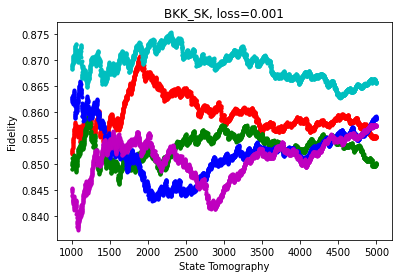

5000 state tomography fidelity 0.857


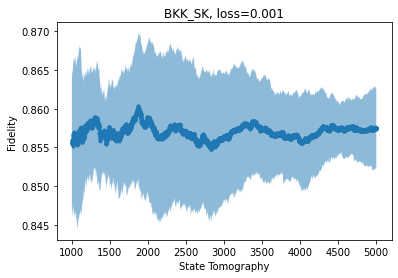

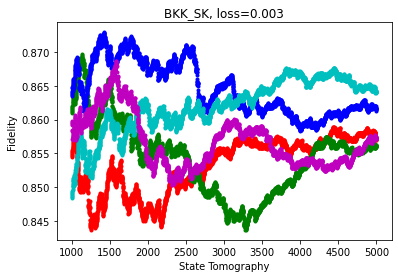

5000 state tomography fidelity 0.859


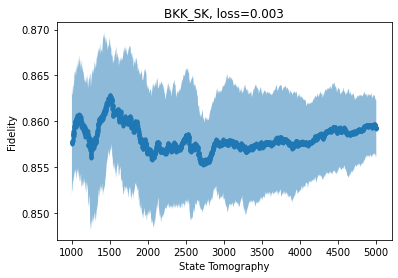

0.859

In [18]:
plot_all(openPickle('BKK_SK_0.001_err'), 1000, 5000, 'BKK_SK, loss=0.001') # simulation time = 8.10 min
plot_all(openPickle('BKK_SK_0.003_err'), 1000, 5000, 'BKK_SK, loss=0.003') # simulation time = 46 min